#### Import required python packages including pytorch-1.7.0, transformers-3.1.0, and seqeval for performance evaluation on Google Colab.

In [1]:
!pip3 install transformers==3.1.0

     |████████████████████████████████| 890kB 5.3MB/s 
     |████████████████████████████████| 3.0MB 29.3MB/s 
     |████████████████████████████████| 890kB 51.8MB/s 
     |████████████████████████████████| 1.1MB 51.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=46e9d3f0d933f49866ac022e20fefd462541bfd19cef95b594d4b70c948e9633
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
! ls /content/drive/My\ Drive/NLP_NER

In [3]:
!pip3 install seqeval

     |████████████████████████████████| 51kB 2.6MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp36-none-any.whl size=16171 sha256=bb04fbf6f7a4dc4b728de751245437fb74745adc44e9f55e21f53611343f2cee
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [4]:
import os
import time
import numpy as np
from tqdm import tqdm, trange
import codecs
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig
from tensorflow.keras.preprocessing.sequence import pad_sequences
import transformers
from transformers import BertForTokenClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from seqeval.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report

print(transformers.__version__)
print(torch.__version__)

3.1.0
1.7.0+cu101


Set the path of dataset.

In [ ]:
data_path = '/content/drive/My Drive/NLP_NER/CONLL2003/'

fnames = os.listdir(data_path)
fnames.sort()
print(fnames)

data_files = []
for f in fnames:
    data_files.append(os.path.join(data_path, f))
print(data_files)

In [6]:
word_count = {}
tag_count = {}
word_train = []
train_tag = []
word_val = []
val_tag = []
word_test = []
test_tag = []
corpus_dic = {'word_test': word_test, 'test_tag': test_tag, 
              'word_val': word_val, 'val_tag': val_tag, 
              'word_train': word_train, 'train_tag': train_tag}
corpus_list = ['word_test', 'test_tag', 'word_train', 
               'train_tag', 'word_val', 'val_tag']
corpus_dic

{'test_tag': [],
 'train_tag': [],
 'val_tag': [],
 'word_test': [],
 'word_train': [],
 'word_val': []}

Import three datasets

In [7]:
for i, f in enumerate(data_files):
    with codecs.open(f, encoding='utf-8') as fid:
        for l in fid:
            if l == '\r\n' or l == '\n': continue
                
            l = l.replace('\r\n', '')
            t = l.split()
            corpus_dic[corpus_list[2*i]].append(t[0])
            corpus_dic[corpus_list[2*i+1]].append(t[1])

In [8]:
for i in range(len(data_files)):
    for w in corpus_dic[corpus_list[2*i]]:
        if w in word_count:
            word_count[w] += 1
        else:
            word_count[w] = 1
    
    for t in corpus_dic[corpus_list[2*i+1]]:
        if t in tag_count:
            tag_count[t] += 1
        else:
            tag_count[t] = 1

In [9]:
tag_count
#print(word_count)

{'B-LOC': 8977,
 'B-MISC': 4360,
 'B-ORG': 7662,
 'B-PER': 8442,
 'I-LOC': 1414,
 'I-MISC': 1501,
 'I-ORG': 4455,
 'I-PER': 5835,
 'O': 260165}

In [10]:
wcounts = list(word_count.items())
wcounts.sort(key=lambda x: x[1], reverse=True)
word_sorted = [w[0] for w in wcounts]
word_index = dict(list(zip(word_sorted, list(range(1, len(word_count) + 1)))))
word_index['PAD'] = 0
word_index['UNK'] = len(word_index)

Generate a dictionary of tags

In [11]:
tag_index = {t[0]: i for i, t in enumerate(list(tag_count.items()))}
index_tag = {i: t[0] for i, t in enumerate(list(tag_count.items()))}

Insert PAD label into the dictionary.

In [12]:
tag_index['PAD'] = len(tag_count)
index_tag[len(tag_count)] = 'PAD'

In [13]:
index_tag

{0: 'O',
 1: 'B-ORG',
 2: 'B-MISC',
 3: 'B-PER',
 4: 'I-PER',
 5: 'B-LOC',
 6: 'I-ORG',
 7: 'I-MISC',
 8: 'I-LOC',
 9: 'PAD'}

In [14]:
tag_index

{'B-LOC': 5,
 'B-MISC': 2,
 'B-ORG': 1,
 'B-PER': 3,
 'I-LOC': 8,
 'I-MISC': 7,
 'I-ORG': 6,
 'I-PER': 4,
 'O': 0,
 'PAD': 9}

In [15]:
train_sent = []
train_tag = []
val_sent = []
val_tag = []
test_sent = []
test_tag = []
sentences_corpus = {'test_sent': test_sent, 'test_tag': test_tag, 
                    'val_sent': val_sent, 'val_tag': val_tag, 
                    'train_sent': train_sent, 'train_tag': train_tag}
sent_corpus_list = ['test_sent', 'test_tag', 
                    'train_sent', 'train_tag',
                    'val_sent', 'val_tag']
sentences_corpus

{'test_sent': [],
 'test_tag': [],
 'train_sent': [],
 'train_tag': [],
 'val_sent': [],
 'val_tag': []}

Read all three datasets into a list of lists.

In [16]:
for i, f in enumerate(data_files):
    sent = []
    tag = []
    for l in open(f):
        if l in ['\n', '\r\n']:
            sentences_corpus[sent_corpus_list[2*i]].append(sent)
            sentences_corpus[sent_corpus_list[2*i+1]].append(tag)
            sent = []
            tag = []
        else:
            t = l.replace('\r\n', '').split()
            sent.append(t[0])
            tag.append(t[1])

In [17]:
sentences_corpus[sent_corpus_list[2]]

[['-DOCSTART-'],
 ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'],
 ['Peter', 'Blackburn'],
 ['BRUSSELS', '1996-08-22'],
 ['The',
  'European',
  'Commission',
  'said',
  'on',
  'Thursday',
  'it',
  'disagreed',
  'with',
  'German',
  'advice',
  'to',
  'consumers',
  'to',
  'shun',
  'British',
  'lamb',
  'until',
  'scientists',
  'determine',
  'whether',
  'mad',
  'cow',
  'disease',
  'can',
  'be',
  'transmitted',
  'to',
  'sheep',
  '.'],
 ['Germany',
  "'s",
  'representative',
  'to',
  'the',
  'European',
  'Union',
  "'s",
  'veterinary',
  'committee',
  'Werner',
  'Zwingmann',
  'said',
  'on',
  'Wednesday',
  'consumers',
  'should',
  'buy',
  'sheepmeat',
  'from',
  'countries',
  'other',
  'than',
  'Britain',
  'until',
  'the',
  'scientific',
  'advice',
  'was',
  'clearer',
  '.'],
 ['"',
  'We',
  'do',
  "n't",
  'support',
  'any',
  'such',
  'recommendation',
  'because',
  'we',
  'do',
  "n't",
  'see',
  'any',
 

Set hyperparameters:
* maximum sequence length = 150
* batch size = 32

In [18]:
MAX_LEN = 150
batch_size = 32

Check if GPU is available?

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#n_gpu = torch.cuda.device_count()
device

device(type='cuda')

In [20]:
#torch.cuda.get_device_name(0)
!nvidia-smi

Sat Nov  7 12:59:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    14W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Load the pretrained English BERT tokenizer model from PyTorch Hub.

In [21]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

Tokenize every word into word pieces and clone the tag according to the number of word pieces.

In [22]:
def tokenize_and_preserve_tags(sentence, sent_tags):
    tokenized_sentence = []
    tags = []
    n_tokens = []

    for w, t in zip(sentence, sent_tags):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(w)
        n_subwords = len(tokenized_word)
        n_tokens.append(n_subwords)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels b`n_subwords` times
        tags.extend([t] * n_subwords)

    return tokenized_sentence, tags, n_tokens

Tokenize the training dataset.

In [23]:
train_tokenized_sents_and_tags = [
    tokenize_and_preserve_tags(sent, tag)
    for sent, tag in zip(sentences_corpus['train_sent'], sentences_corpus['train_tag'])
]

In [24]:
print(train_tokenized_sents_and_tags[4])

(['The', 'European', 'Commission', 'said', 'on', 'Thursday', 'it', 'disagreed', 'with', 'German', 'advice', 'to', 'consumers', 'to', 's', '##hun', 'British', 'la', '##mb', 'until', 'scientists', 'determine', 'whether', 'mad', 'cow', 'disease', 'can', 'be', 'transmitted', 'to', 'sheep', '.'], ['O', 'B-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


Split the training dataset into texts, labels and number of tokens of every word.

In [25]:
train_tokenized_texts = [token_label_pair[0] for token_label_pair in train_tokenized_sents_and_tags]
train_labels = [token_label_pair[1] for token_label_pair in train_tokenized_sents_and_tags]
num_tokens = [token_label_pair[2] for token_label_pair in train_tokenized_sents_and_tags]

In [26]:
print(train_tokenized_texts[3])
print(train_labels[3])
print(num_tokens[3])

['BR', '##US', '##SE', '##LS', '1996', '-', '08', '-', '22']
['B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'O', 'O', 'O', 'O', 'O']
[4, 5]


Convert the tokens into indices and add zero padding.

In [27]:
train_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in train_tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [28]:
train_tags = pad_sequences([[tag_index.get(l) for l in lab] for lab in train_labels],
                     maxlen=MAX_LEN, value=tag_index["PAD"], padding="post",
                     dtype="long", truncating="post")

In [29]:
print(train_tokenized_texts[4])
print(train_input_ids[4])
print(train_tags[4])

['The', 'European', 'Commission', 'said', 'on', 'Thursday', 'it', 'disagreed', 'with', 'German', 'advice', 'to', 'consumers', 'to', 's', '##hun', 'British', 'la', '##mb', 'until', 'scientists', 'determine', 'whether', 'mad', 'cow', 'disease', 'can', 'be', 'transmitted', 'to', 'sheep', '.']
[ 1109  1735  2827  1163  1113  9170  1122 19786  1114  1528  5566  1106
 11060  1106   188 17315  1418  2495 12913  1235  6479  4959  2480  6340
 13991  3653  1169  1129 12086  1106  8892   119     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0    

Generate masks for every input sequence to mask the inserted PAD(0) tokens.

In [30]:
train_attention_masks = [[float(i != 0.0) for i in ii] for ii in train_input_ids]
print(train_attention_masks[4])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Load and pre-process the validation dataset.

In [31]:
val_tokenized_sents_and_tags = [
    tokenize_and_preserve_tags(sent, tag)
    for sent, tag in zip(sentences_corpus['val_sent'], sentences_corpus['val_tag'])
]

In [32]:
val_tokenized_texts = [token_label_pair[0] for token_label_pair in val_tokenized_sents_and_tags]
val_labels = [token_label_pair[1] for token_label_pair in val_tokenized_sents_and_tags]

In [33]:
val_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in val_tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")
val_tags = pad_sequences([[tag_index.get(l) for l in lab] for lab in val_labels],
                     maxlen=MAX_LEN, value=tag_index["PAD"], padding="post",
                     dtype="long", truncating="post")

In [34]:
val_attention_masks = [[float(i != 0.0) for i in ii] for ii in val_input_ids]
#print(val_attention_masks[2])

Convert arrays into tensors

In [35]:
train_inputs = torch.tensor(train_input_ids)
val_inputs = torch.tensor(val_input_ids)
train_tags = torch.tensor(train_tags)
val_tags = torch.tensor(val_tags)
train_masks = torch.tensor(train_attention_masks)
val_masks = torch.tensor(val_attention_masks)

Generate data loaders according to the batch size and use random sampler for training dataset and sequential sampler for validation dataset.

In [36]:
training_data = TensorDataset(train_inputs, train_masks, train_tags)
training_sampler = RandomSampler(training_data)
training_dataloader = DataLoader(training_data, sampler=training_sampler, batch_size=batch_size)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=batch_size)

In [37]:
training_data[4]

(tensor([ 1109,  1735,  2827,  1163,  1113,  9170,  1122, 19786,  1114,  1528,
          5566,  1106, 11060,  1106,   188, 17315,  1418,  2495, 12913,  1235,
          6479,  4959,  2480,  6340, 13991,  3653,  1169,  1129, 12086,  1106,
          8892,   119,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

Load the pretrained English BERT model for token classification from PyTorch Hub.

In [38]:
ner_model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag_index),
    output_attentions = False,
    output_hidden_states = False
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [39]:
ner_model.cuda();

Set to full finetune the pretrained bert model and choose the AdamW optimizer.

In [40]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(ner_model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(ner_model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

Set hyperparameters

In [41]:
epochs = 4
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(training_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [42]:
tick1 = time.time()
localtime = time.asctime(time.localtime(time.time()))
print("開始時間是：", localtime)

開始時間是： Sat Nov  7 12:59:46 2020


### Training loop and validation loop

In [43]:
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================

    # Set the ner model to training mode.
    ner_model.train()
    total_loss = 0

    # Training loop
    for step, batch in enumerate(training_dataloader):
        # add batch to device (gpu or cpu)
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # reset gradients before performing a backward pass.
        ner_model.zero_grad()
        # forward pass, get the training loss
        outputs = ner_model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the training loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        total_loss += loss.item()
        # Clip the norm of the gradient to prevent from the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=ner_model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(training_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================

    # Set the ner model to evaluation mode
    ner_model.eval()
    # Reset the validation loss
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Don't need to compute gradients
        with torch.no_grad():
            # Forward pass, calculate the predicted logits
            outputs = ner_model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    
    pred_tags = []
    valid_tags = []
    for p, l in zip(predictions, true_labels):
        preds = []
        labs = []
        for p_i, l_i in zip(p, l):
            if index_tag[l_i] != "PAD":
                preds.append(index_tag[p_i])
                labs.append(index_tag[l_i])
        pred_tags.append(preds)
        valid_tags.append(labs)
    
    print("Validation Precision: {}".format(precision_score(valid_tags, pred_tags)))
    print("Validation Recall: {}".format(recall_score(valid_tags, pred_tags)))
    print("Validation Accuracy: {}".format(accuracy_score(valid_tags, pred_tags)))
    print("Validation F1-Score: {}".format(f1_score(valid_tags, pred_tags)))
    print("Report: {}".format(classification_report(valid_tags, pred_tags)))
    print()

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Average train loss: 0.22753008363295846
Validation loss: 0.07925253793054662
Validation Precision: 0.9026753177495334
Validation Recall: 0.9111788982594653
Validation Accuracy: 0.9765764468758998
Validation F1-Score: 0.9069071750680895


Epoch:  25%|██▌       | 1/4 [07:15<21:47, 435.68s/it]

Report:               precision    recall  f1-score   support

         LOC       0.93      0.92      0.93      3635
        MISC       0.76      0.85      0.80      1480
         ORG       0.92      0.87      0.89      2702
         PER       0.93      0.96      0.95      3329

   micro avg       0.90      0.91      0.91     11146
   macro avg       0.88      0.90      0.89     11146
weighted avg       0.91      0.91      0.91     11146


Average train loss: 0.059027369971623396
Validation loss: 0.06315587412025524
Validation Precision: 0.9239043470530713
Validation Recall: 0.9324421317064417
Validation Accuracy: 0.9828246472790095
Validation F1-Score: 0.9281536057155614


Epoch:  50%|█████     | 2/4 [14:33<14:32, 436.29s/it]

Report:               precision    recall  f1-score   support

         LOC       0.96      0.94      0.95      3635
        MISC       0.81      0.89      0.84      1480
         ORG       0.91      0.91      0.91      2702
         PER       0.95      0.97      0.96      3329

   micro avg       0.92      0.93      0.93     11146
   macro avg       0.91      0.92      0.92     11146
weighted avg       0.93      0.93      0.93     11146


Average train loss: 0.03202918644742306
Validation loss: 0.0643791331316306
Validation Precision: 0.9312929419113054
Validation Recall: 0.9363897362282433
Validation Accuracy: 0.9843075151166139
Validation F1-Score: 0.9338343846463562


Epoch:  75%|███████▌  | 3/4 [21:50<07:16, 436.48s/it]

Report:               precision    recall  f1-score   support

         LOC       0.96      0.95      0.95      3635
        MISC       0.86      0.86      0.86      1480
         ORG       0.89      0.92      0.91      2702
         PER       0.97      0.96      0.97      3329

   micro avg       0.93      0.94      0.93     11146
   macro avg       0.92      0.92      0.92     11146
weighted avg       0.93      0.94      0.93     11146


Average train loss: 0.018468667692102706
Validation loss: 0.06608398310805953
Validation Precision: 0.9347690664768177
Validation Recall: 0.942400861295532
Validation Accuracy: 0.9851857183990786
Validation F1-Score: 0.9385694500290399


Epoch: 100%|██████████| 4/4 [29:07<00:00, 436.80s/it]

Report:               precision    recall  f1-score   support

         LOC       0.96      0.95      0.96      3635
        MISC       0.85      0.89      0.87      1480
         ORG       0.91      0.92      0.92      2702
         PER       0.96      0.97      0.97      3329

   micro avg       0.93      0.94      0.94     11146
   macro avg       0.92      0.93      0.93     11146
weighted avg       0.94      0.94      0.94     11146




Train the BERT NER prediction model 4 epochs and the final F1-Score is 0.94

In [44]:
localtime = time.asctime(time.localtime(time.time()))
print("結束時間是：", localtime)

tick2 = time.time()
print("Elapsed time: ", tick2 - tick1)
print(time.strftime("%H:%M:%S", time.localtime(tick2-tick1-3600*8)))

結束時間是： Sat Nov  7 13:28:53 2020
Elapsed time:  1747.3136377334595
16:29:07


 #### Save the model

In [45]:
ner_model.train()
torch.save(ner_model, '/content/drive/My Drive/NLP_NER/bert_ner.pt')

#### Load the model

In [47]:
#ner_model = torch.load('bert_ner.pt', map_location=torch.device('cpu'))
ner_model = torch.load('/content/drive/My Drive/NLP_NER/bert_ner.pt')
ner_model.eval()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

Plot the learning curve of the model

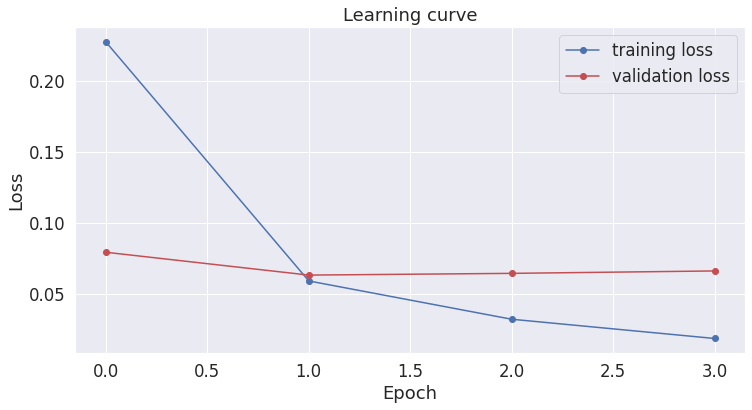

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

Use the trained BERT NER model to infer the named entities of the test sentence.

In [49]:
test_sentence = """The European Commission said on Thursday it disagreed with German 
advice to consumers to shun British lamb until scientists determine whether mad cow 
disease can be transmitted to sheep."""

tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()
#input_ids = torch.tensor([tokenized_sentence])

with torch.no_grad():
    output = ner_model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(index_tag[label_idx])
        new_tokens.append(token)
        
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

O	[CLS]
O	The
B-ORG	European
I-ORG	Commission
O	said
O	on
O	Thursday
O	it
O	disagreed
O	with
B-MISC	German
O	advice
O	to
O	consumers
O	to
O	shun
B-MISC	British
O	lamb
O	until
O	scientists
O	determine
O	whether
O	mad
O	cow
O	disease
O	can
O	be
O	transmitted
O	to
O	sheep
O	.
O	[SEP]


Load and pre-process the test dataset

In [50]:
test_tokenized_sents_and_tags = [
    tokenize_and_preserve_tags(sent, tag)
    for sent, tag in zip(sentences_corpus['test_sent'], sentences_corpus['test_tag'])
]

In [51]:
test_tokenized_texts = [token_label_pair[0] for token_label_pair in test_tokenized_sents_and_tags]
test_labels = [token_label_pair[1] for token_label_pair in test_tokenized_sents_and_tags]
num_tokens = [token_label_pair[2] for token_label_pair in test_tokenized_sents_and_tags]

In [52]:
test_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in test_tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [53]:
test_tags = pad_sequences([[tag_index.get(l) for l in lab] for lab in test_labels],
                     maxlen=MAX_LEN, value=tag_index["PAD"], padding="post",
                     dtype="long", truncating="post")

In [54]:
test_attention_masks = [[float(i != 0.0) for i in ii] for ii in test_input_ids]
#print(test_attention_masks[3])

In [55]:
test_inputs = torch.tensor(test_input_ids)
test_tags = torch.tensor(test_tags)
test_masks = torch.tensor(test_attention_masks)

In [56]:
test_data = TensorDataset(test_inputs, test_masks, test_tags)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

Predict the named entities of the test dataset

In [57]:
%%time

test_pred_tags, test_predictions = [], []
test_true_labels, test_token_ids, test_input_tokens = [], [], []
for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        # Forward pass, calculate the predicted logits
        outputs = ner_model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask)#, labels=b_labels)
    # Move logits and labels to CPU
    logits = outputs[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    token_ids = b_input_ids.to('cpu').numpy()
    
    test_predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    test_true_labels.extend(label_ids)
    test_token_ids.extend(token_ids)
    
for p, l in zip(test_predictions, test_true_labels):
    preds = []
    labs = []
    for p_i, l_i in zip(p, l):
        if index_tag[l_i] != "PAD":
            preds.append(index_tag[p_i])                
    test_pred_tags.append(preds)
    
for ids in test_token_ids:
    token = []
    for t in ids:
        if t != 0:
            token.append(t)    
    test_input_tokens.append(tokenizer.convert_ids_to_tokens(token))

CPU times: user 21.8 s, sys: 16.7 s, total: 38.5 s
Wall time: 38.5 s


In [58]:
new_tokens, new_tags = [], []
for tokens, tags in zip(test_input_tokens, test_pred_tags):
    new_tok, new_t = [], []
    for t, tag in zip(tokens, tags):
        if t.startswith("##"):
            new_tok[-1] = new_tok[-1] + t[2:]
        else:
            new_t.append(tag)
            new_tok.append(t)
    new_tokens.append(new_tok)
    new_tags.append(new_t)

In [59]:
pred_tags = []
for i in test_pred_tags:
    pred_tags.extend(i)
#pred_tags

In [60]:
n_token = []
for i in num_tokens:
    n_token.extend(i)
#n_token

Save the predicted named entities to test-submit.txt

In [61]:
%%time

submit = '/content/drive/My Drive/NLP_NER/test-submit.txt'
test = '/content/drive/My Drive/NLP_NER/CONLL2003/test-sample.txt'
fid2 = open(submit, 'w', encoding='UTF-8')
i = 0
j = 0
with codecs.open(test, encoding='utf-8') as fid:
    for l in fid:
        if l == '\r\n' or l == '\n': 
            print(l, end='')
            fid2.write(l)
        else:
            l = l.replace('\r\n', '')
            line = l.rstrip()[:-1]+pred_tags[i]+'\n'
            i = i + n_token[j]
            j = j + 1
            print(line, end='')
            fid2.write(line)
fid2.close()

串流輸出內容已截斷至最後 5000 行。
22 O
7 O
7 O
8 O
25 O
28 O
28 O

Port B-ORG
Vale I-ORG
22 O
6 O
10 O
6 O
19 O
22 O
28 O

Ipswich B-ORG
22 O
6 O
8 O
8 O
27 O
32 O
26 O

Manchester B-ORG
City I-ORG
22 O
8 O
2 O
12 O
26 O
35 O
26 O

Portsmouth B-ORG
22 O
7 O
5 O
10 O
25 O
29 O
26 O

Reading B-ORG
22 O
7 O
5 O
10 O
25 O
33 O
26 O

West B-ORG
Bromwich I-ORG
20 O
5 O
9 O
6 O
26 O
31 O
24 O

Southend B-ORG
22 O
5 O
9 O
8 O
23 O
36 O
24 O

Grimsby B-ORG
22 O
5 O
6 O
11 O
24 O
41 O
21 O

Bradford B-ORG
22 O
5 O
6 O
11 O
21 O
37 O
21 O

Oldham B-ORG
22 O
4 O
8 O
10 O
23 O
28 O
20 O

Division O
Two O

Brentford B-ORG
22 O
11 O
7 O
4 O
35 O
23 O
40 O

Millwall B-ORG
22 O
11 O
7 O
4 O
32 O
22 O
40 O

Bury B-ORG
21 O
11 O
6 O
4 O
33 O
20 O
39 O

Luton B-ORG
21 O
11 O
4 O
6 O
34 O
25 O
37 O

Burnley B-ORG
22 O
11 O
4 O
7 O
30 O
22 O
37 O

Chesterfield B-ORG
21 O
11 O
4 O
6 O
22 O
16 O
37 O

Stockport B-ORG
22 O
10 O
6 O
6 O
29 O
25 O
36 O

Watford B-ORG
21 O
9 O
9 O
3 O
24 O
18 O
36 O

Wrexham B-ORG
20 O
9 O
8 

### BERT Named Entity Recognition

Named entities are phrases that contain the names of persons, organizations, locations, times and quantities.

* U.N. (organization) official Ekeus (person) heads for Baghdad (location)

The dataset **CoNLL-2003** concerns named entity recognition is used. There are four types of named entities: persons, locations, organizations and names of miscellaneous entities that do not belong to the previous three groups. The named entity tags have format B-TYPE, I-TYPE, O. The first word of the entity will have tag B-TYPE. I-TYPE means that the word is inside an entity of type TYPE. A word with tag O is not part of any entities.

There are 9 entity tags in this task (B-LOC, B-PER, B-ORG, B-MISC, I-LOC, I-PER, I-ORG, I-MISC, O). Here is an example:
```
AL-AIN B-LOC
, O
United B-LOC
Arab I-LOC
Emirates I-LOC
1996-12-06 O
```

#### Evaluation

test_sentence:
The European Commission said on Thursday it disagreed with German advice to consumers to shun British lamb until scientists determine whether mad cow disease can be transmitted to sheep.

test result:
```
O	[CLS]
O	The
B-ORG	European
I-ORG	Commission
O	said
O	on
O	Thursday
O	it
O	disagreed
O	with
B-MISC	German
O	advice
O	to
O	consumers
O	to
O	shun
B-MISC	British
O	lamb
O	until
O	scientists
O	determine
O	whether
O	mad
O	cow
O	disease
O	can
O	be
O	transmitted
O	to
O	sheep
O	.
O	[SEP]
```

![BERT model for transfer learning: use a pre-trained BERT model and fine tune for your downstream NLP tasks](images/bert-2phase.jpg)

![4 NLP tasks based on a fine-tuned BERT model](images/bert_fine_tuning_tasks.jpg)

#### See also

* [Introduction to BERT by Hung-Yi Lee](https://youtu.be/UYPa347-DdE)
